# EDA - Resume NER Dataset

Analysis focusing on:
1. Sentence length → input sequence size
2. Tag distribution → class balance
3. Tag sequences → prediction difficulty
4. Vocabulary → preprocessing decisions


In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)

In [34]:
DATASET_PATH = Path("../dataset/train.json")

with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Samples: {len(data):,}")


Samples: 5,960


In [35]:
import re

sentence_lengths = []
for sample in data:
    sentences = re.split(r'[.!?]+', sample['text'])
    for sentence in sentences:
        words = sentence.strip().split()
        if words:
            sentence_lengths.append(len(words))

sentence_lengths_df = pd.DataFrame({'length': sentence_lengths})
median_len = sentence_lengths_df['length'].median()
mean_len = sentence_lengths_df['length'].mean()
p95_len = sentence_lengths_df['length'].quantile(0.95)

print(f"Sentences: {len(sentence_lengths):,}")
print(f"Median: {median_len:.1f}, Mean: {mean_len:.1f}, P95: {p95_len:.1f} words")


Sentences: 251,832
Median: 9.0, Mean: 14.0, P95: 41.0 words


| Metric                |        Value | Meaning                                                  |
| --------------------- | -----------: | -------------------------------------------------------- |
| Total sentences       |  **251,832** | Number of sentences after splitting text by `. ! ?`      |
| Median length         |  **9 words** | 50% of sentences have ≤ 9 words                          |
| Mean length           | **14 words** | Average sentence length (right-skewed by long sentences) |
| 95th percentile (p95) | **41 words** | 95% of sentences have ≤ 41 words                         |


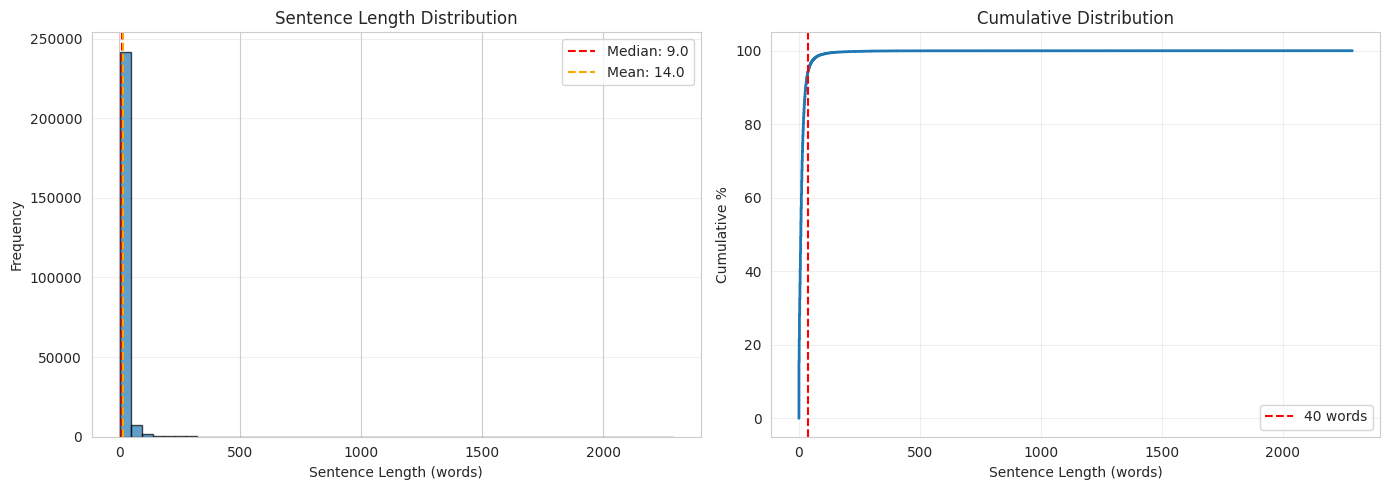

Decision: 40 words covers 94.8% of sentences


In [36]:
SUGGESTED_SEQUENCE_LENGTH = 40

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(sentence_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(median_len, color='red', linestyle='--', label=f'Median: {median_len:.1f}')
axes[0].axvline(mean_len, color='orange', linestyle='--', label=f'Mean: {mean_len:.1f}')
axes[0].set_xlabel('Sentence Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sentence Length Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

sorted_lengths = np.sort(sentence_lengths)
percentiles = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
axes[1].plot(sorted_lengths, percentiles, linewidth=2)
axes[1].axvline(SUGGESTED_SEQUENCE_LENGTH, color='red', linestyle='--', label=f'{SUGGESTED_SEQUENCE_LENGTH} words')
axes[1].set_xlabel('Sentence Length (words)')
axes[1].set_ylabel('Cumulative %')
axes[1].set_title('Cumulative Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

coverage = (sentence_lengths_df['length'] <= SUGGESTED_SEQUENCE_LENGTH).sum() / len(sentence_lengths_df) * 100
print(f"Decision: {SUGGESTED_SEQUENCE_LENGTH} words covers {coverage:.1f}% of sentences")

| Aspect             | Why 40 works                     |
| ------------------ | -------------------------------- |
| Coverage           | ~95% of sentences preserved      |
| Padding            | Acceptable (median is only 9)    |
| Truncation risk    | Limited to rare long sentences   |
| Entity integrity   | Most entities fit well within 40 |
| Compute efficiency | Much cheaper than 64 / 128       |


In [28]:
def create_bio_tags(text, annotations):
    """Convert character-level annotations to token-level BIO tags."""
    tokens = text.split()
    tags = ['O'] * len(tokens)
    
    char_to_token = {}
    char_idx = 0
    for token_idx, token in enumerate(tokens):
        for _ in token:
            char_to_token[char_idx] = token_idx
            char_idx += 1
        char_idx += 1
    
    for start, end, entity_type in annotations:
        start_token = char_to_token.get(start)
        end_token = char_to_token.get(end - 1)
        if start_token is not None and end_token is not None:
            for token_idx in range(start_token, end_token + 1):
                if token_idx < len(tags):
                    tags[token_idx] = f'B-{entity_type}' if token_idx == start_token else f'I-{entity_type}'
    
    return tokens, tags

all_tags = []
b_tags = defaultdict(int)
i_tags = defaultdict(int)

for sample in data:
    tokens, tags = create_bio_tags(sample['text'], sample['annotations'])
    all_tags.extend(tags)
    for tag in tags:
        if tag.startswith('B-'):
            b_tags[tag[2:]] += 1
        elif tag.startswith('I-'):
            i_tags[tag[2:]] += 1

total_tokens = len(all_tags)
o_count = all_tags.count('O')
entity_count = total_tokens - o_count
entity_types = sorted(set(list(b_tags.keys()) + list(i_tags.keys())))

print(f"Tokens: {total_tokens:,} | O: {o_count/total_tokens*100:.1f}% | Entities: {entity_count/total_tokens*100:.1f}%")
print(f"\nEntity types ({len(entity_types)}):")
for entity_type in sorted(entity_types, key=lambda x: b_tags[x] + i_tags[x], reverse=True):
    total = b_tags[entity_type] + i_tags[entity_type]
    pct = (total / entity_count) * 100
    ratio = b_tags[entity_type] / i_tags[entity_type] if i_tags[entity_type] > 0 else float('inf')
    print(f"  {entity_type:15s}: {total:6,} ({pct:5.2f}%) | B/I: {ratio:.2f}")

Tokens: 3,452,763 | O: 79.0% | Entities: 21.0%

Entity types (14):
  SKILL          : 658,084 (90.85%) | B/I: 0.98
  OTHER          : 18,831 ( 2.60%) | B/I: 0.57
  DESIGNATION    :  9,970 ( 1.38%) | B/I: 0.45
  LOCATION       :  7,564 ( 1.04%) | B/I: 0.59
  PERSON         :  7,555 ( 1.04%) | B/I: 0.40
  EXPERIENCE     :  7,346 ( 1.01%) | B/I: 0.49
  EDUCATION      :  5,992 ( 0.83%) | B/I: 0.32
  EXPERTISE      :  5,783 ( 0.80%) | B/I: 0.15
  EMAIL          :  1,046 ( 0.14%) | B/I: 0.78
  COLLABORATION  :    780 ( 0.11%) | B/I: 0.19
  ACTION         :    521 ( 0.07%) | B/I: 0.22
  COMPANY        :    448 ( 0.06%) | B/I: 0.51
  CERTIFICATION  :    280 ( 0.04%) | B/I: 0.31
  LANGUAGE       :    184 ( 0.03%) | B/I: 0.63


| Overall Dataset Summary |         Value |
| ----------------------- | ------------: |
| Total tokens            | **3,452,763** |
| Outside (`O`) tokens    |     **79.0%** |
| Entity tokens (B + I)   |     **21.0%** |
| Number of entity types  |        **14** |


| Entity Type   | B/I Ratio | Typical Span Length |
| ------------- | --------: | ------------------- |
| SKILL         |      0.98 | Mostly single-word  |
| OTHER         |      0.57 | Short phrases       |
| DESIGNATION   |      0.45 | Multi-word          |
| LOCATION      |      0.59 | Short phrases       |
| PERSON        |      0.40 | Multi-word names    |
| EXPERIENCE    |      0.49 | Multi-word          |
| EDUCATION     |      0.32 | Longer phrases      |
| EXPERTISE     |  **0.15** | Longest spans       |
| EMAIL         |      0.78 | Single-token        |
| COLLABORATION |      0.19 | Long spans          |
| ACTION        |      0.22 | Multi-word          |
| COMPANY       |      0.51 | Short phrases       |
| CERTIFICATION |      0.31 | Long phrases        |
| LANGUAGE      |      0.63 | Mostly single-word  |

In [38]:
def extract_tag_sequences(tags):
    """Extract consecutive sequences of the same entity type."""
    sequences = []
    current_entity = None
    current_length = 0
    
    for tag in tags:
        if tag == 'O':
            if current_entity is not None:
                sequences.append((current_entity, current_length))
                current_entity = None
                current_length = 0
        elif tag.startswith('B-'):
            if current_entity is not None:
                sequences.append((current_entity, current_length))
            current_entity = tag[2:]
            current_length = 1
        elif tag.startswith('I-'):
            entity_type = tag[2:]
            if current_entity == entity_type:
                current_length += 1
            else:
                if current_entity is not None:
                    sequences.append((current_entity, current_length))
                current_entity = entity_type
                current_length = 1
    
    if current_entity is not None:
        sequences.append((current_entity, current_length))
    
    return sequences

all_sequences = []
sequence_by_type = defaultdict(list)

for sample in data:
    tokens, tags = create_bio_tags(sample['text'], sample['annotations'])
    for entity_type, length in extract_tag_sequences(tags):
        all_sequences.append((entity_type, length))
        sequence_by_type[entity_type].append(length)

sequence_lengths = [length for _, length in all_sequences]
sequence_df = pd.DataFrame({'length': sequence_lengths})

median_seq = sequence_df['length'].median()
mean_seq = sequence_df['length'].mean()
max_seq = sequence_df['length'].max()

print(f"Sequences: {len(all_sequences):,}, Median: {median_seq:.1f}, Mean: {mean_seq:.1f}, Max: {max_seq}")


Sequences: 346,164, Median: 2.0, Mean: 2.1, Max: 240


| Metric                 |          Value | What it Means                                 |
| ---------------------- | -------------: | --------------------------------------------- |
| Total entity sequences |    **346,164** | Number of labeled entity mentions (B–I spans) |
| Median entity length   |   **2 tokens** | 50% of entities are 1–2 tokens long           |
| Mean entity length     | **2.1 tokens** | Average entity span is very short             |
| Maximum entity length  | **240 tokens** | Rare extreme long entity spans                |


In [40]:
all_tokens = []
for sample in data:
    all_tokens.extend([t.lower() for t in sample['text'].split()])

token_counter = Counter(all_tokens)
total_occurrences = len(all_tokens)
vocab_size = len(token_counter)

print(f"Tokens: {total_occurrences:,}, Vocabulary: {vocab_size:,}")
print("\nTop 10 tokens:")
for token, count in token_counter.most_common(10):
    print(f"  '{token:15s}': {count:8,} ({count/total_occurrences*100:.2f}%)")


Tokens: 3,452,763, Vocabulary: 211,458

Top 10 tokens:
  'and            ':  135,924 (3.94%)
  'of             ':   91,030 (2.64%)
  'the            ':   68,455 (1.98%)
  'to             ':   62,485 (1.81%)
  'in             ':   55,602 (1.61%)
  'for            ':   36,758 (1.06%)
  ':              ':   30,786 (0.89%)
  '&              ':   29,583 (0.86%)
  'with           ':   29,222 (0.85%)
  'a              ':   25,058 (0.73%)


The dataset contains ~3.45M tokens with an extremely large vocabulary (~211k unique words), dominated by common stopwords, indicating high lexical diversity and strong justification for subword or character-level modeling in NER.

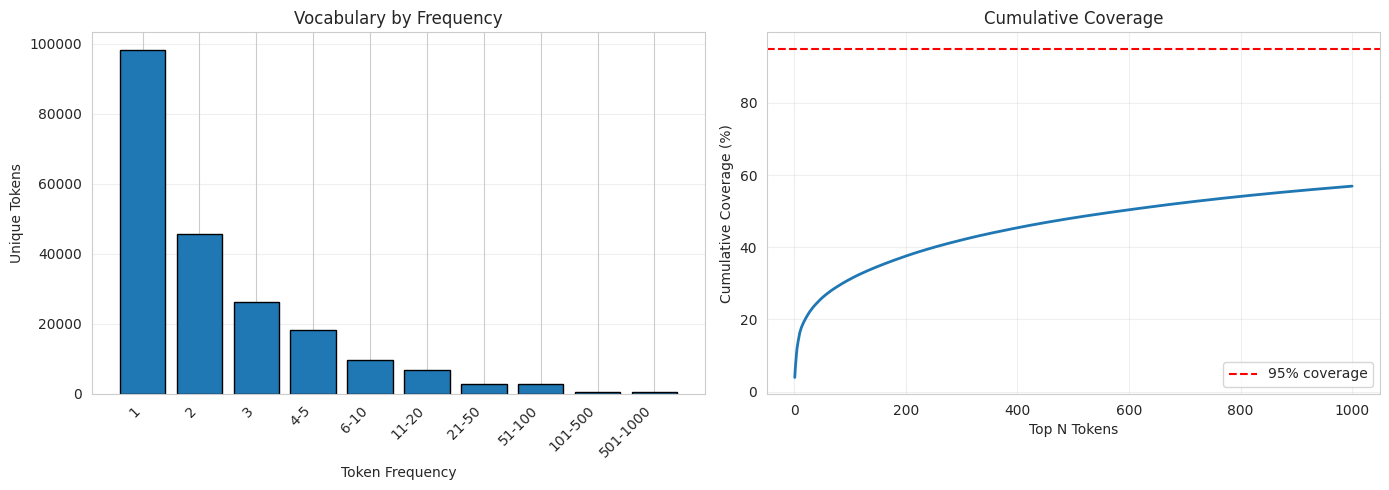

In [43]:
vocab_freq_2_or_less = sum(1 for count in token_counter.values() if count <= 2)
tokens_affected_by_unk = sum(count for token, count in token_counter.items() if count <= 2)

freq_bins = [1, 2, 3, 5, 10, 20, 50, 100, 500, 1000, float('inf')]
freq_labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21-50', '51-100', '101-500', '501-1000', '1000+']
freq_counts = [0] * (len(freq_bins) - 1)

for token, count in token_counter.items():
    for i in range(len(freq_bins) - 1):
        if freq_bins[i] <= count < freq_bins[i + 1]:
            freq_counts[i] += 1
            break

sorted_tokens = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)
cumulative_coverage = []
cumulative_count = 0
for token, count in sorted_tokens:
    cumulative_count += count
    cumulative_coverage.append(cumulative_count / total_occurrences * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(freq_counts)), freq_counts, edgecolor='black')
axes[0].set_xticks(range(len(freq_counts)))
axes[0].set_xticklabels(freq_labels[:len(freq_counts)], rotation=45, ha='right')
axes[0].set_xlabel('Token Frequency')
axes[0].set_ylabel('Unique Tokens')
axes[0].set_title('Vocabulary by Frequency')
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(range(1, min(1000, len(cumulative_coverage)) + 1), 
             cumulative_coverage[:1000], linewidth=2)
axes[1].axhline(95, color='red', linestyle='--', label='95% coverage')
axes[1].set_xlabel('Top N Tokens')
axes[1].set_ylabel('Cumulative Coverage (%)')
axes[1].set_title('Cumulative Coverage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Left plot - Vocabulary by Frequency**:
- The largest bars are at frequency = 1 and 2
- This means:
  - A huge portion of your vocabulary consists of very rare words
  - Most words appear once or twice only

**Right plot - Cumulative Coverage**:
- The curve rises quickly at first, then flattens
- Even the top 1,000 tokens only cover ~55–60% of all token occurrences
- The dashed red line at 95% coverage is far above what small vocabularies can reach

The vocabulary exhibits a strong long-tail distribution, with most tokens appearing once or twice. Replacing rare tokens (**frequency ≤2**) with UNK significantly reduces vocabulary size while affecting only a small fraction of token occurrences. 

Stopwords are retained as they provide essential contextual information for entity boundaries. Subword modeling is preferred to handle the remaining lexical sparsity.

## Key Decisions Based on Data Analysis

### Set maximum sequence length to 40 tokens

**Evidence**

* Median sentence length: **9 words**
* 95th percentile: **~41 words**
* 40 tokens cover **~95% of sentences**

**Decision**

* `max_sequence_length = 40`

**Rationale**

* Minimizes padding and compute
* Limits truncation to rare long sentences
* Much cheaper than 64 / 128 with negligible coverage loss

### Use macro / entity-level F1 for evaluation

**Evidence**

* `O` tokens = **79%**
* SKILL = **~91% of entity tokens**
* Severe class imbalance

**Decision**

* Optimize for **macro-F1** and **entity-level F1**
* Do not rely on accuracy

**Rationale**

* Accuracy would overestimate performance
* Rare entities must be explicitly weighted

### Replace rare tokens (frequency ≤ 2) with UNK

**Evidence**

* Majority of vocabulary appears **once or twice**
* Replacing freq ≤ 2:
	* Removes large portion of vocabulary
	* Affects only a small % of token occurrences

**Decision**

* Map tokens with frequency ≤ 2 to `UNK`

**Rationale**

* Dramatically reduces vocabulary size
* Minimal information loss
* Improves training stability and memory usage

### Do NOT remove stopwords

**Evidence**

* Stopwords dominate top-frequency tokens
* Appear inside entity spans (e.g., EDUCATION, DESIGNATION)

**Decision**

* Keep stopwords intact

**Rationale**

* Removing them breaks entity boundaries
* They provide essential contextual cues

### Prefer subword or character-level modeling

**Evidence**

* Vocabulary size: **~211k**
* Top 1,000 tokens cover only **~55–60%** of occurrences
* Strong long-tail lexical distribution

**Decision**

* Use **subword tokenization (BPE / WordPiece)** or
* Character-aware embeddings (FastText / char-CNN)

**Rationale**

* Handles lexical sparsity
* Eliminates true OOV tokens
* Preserves information from rare names, skills, emails

### Treat entity spans explicitly (span-aware modeling)

**Evidence**

* Median entity length: **2 tokens**
* Max entity length: **240 tokens**
* Long-span entities are rare but error-prone

**Decision**

* Use span-aware decoding (CRF or structured decoding)
* Track entity-level errors

**Rationale**

* Token-level accuracy hides span failures
* Long entities dominate recall errors

### Tune class weighting carefully

**Evidence**

* Extreme dominance of SKILL
* Several entity types < 0.1% of entity tokens

**Decision**

* Use class-weighted loss with smoothing
* Avoid naïve inverse-frequency weighting

**Rationale**

* Prevents collapse on dominant classes
* Improves recall for rare entities